<a href="https://colab.research.google.com/github/jnthnoz/tests/blob/main/examen_rappicard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelos para predicción de fraude en tarjetas de crédito

In [1]:
# Leer la base de datos:

import pandas as pd
excel = pd.read_excel('/content/ds_challenge_data_2022.xlsx')

In [2]:
# Explorar la base de datos:
excel.head()

,transaction_id,user_id,género,linea_tc,interes_tc,monto,fecha,hora,anio_dispositivo,marca_dispositivo,proveedor_dispositivo,establecimiento,ciudad,status_txn,is_prime,dcto,cashback,fraude
0,1,573,M,87000,56,581.03,2020-01-02,0,2019,Apple,Telcel,Farmacia,Ciudad de México,Aceptada,False,0.0,17.43,False
1,2,737,F,34000,51,421.73,2020-01-02,0,2021,Huawei,ATT,Tienda departamental,Cancún,Aceptada,False,0.0,12.65,False
2,3,887,F,52000,38,399.55,2020-01-02,0,2017,Apple,ATT,Farmacia,Tijuana,En proceso,False,0.0,11.99,False
3,4,1304,M,67000,60,828.01,2020-01-02,0,2019,Samsung,ATT,Tienda departamental,Ciudad de México,En proceso,False,0.0,24.84,False
4,5,1361,F,28000,52,886.04,2020-01-02,0,2021,Samsung,Telcel,Supermercado,Cancún,Aceptada,False,0.0,26.58,False


Tras separar la información del dispositivo en columnas, la base de datos cuenta con 3 nuevas variables que corresponden al año, la marca y el proveedor del dispositivo. Esto se lleva a cabo con expresiones regulares en Python.

Como existe **class imbalance** en la etiqueta que deseamos aprender a predecir porque solo el 3% de los datos pertenecen a registros fraudulentos, más adelante veremos que medir la **precisión** no será la métrica más útil para comparar o determinar el *performance* del modelo. En seguida veremos por qué.

In [3]:
excel['fraude'].value_counts()

False    26165
True       810
Name: fraude, dtype: int64

In [4]:
excel['fraude'][excel['fraude'] == False].count()/excel['fraude'].count()

0.9699721964782205

In [5]:
excel['fraude'][excel['fraude'] == True].count()/excel['fraude'].count()

0.030027803521779424

Ya que existen 26,165 observaciones calificadas como 'no fraudulentas' (97% de las observaciones) y solo 810 (3% de las observaciones) 'fraudulentas', si creáramos un modelo que calificara a todas las transacciones como legítimas, nuestro modelo calificaría correctamente el 97% de los registros, es decir, el modelo tendría una precisión del 97%. Sin embargo, sería un modelo que predice muy mal cuando una transacción es fraudulenta. Por eso conviene no medir el *performance* del modelo en base solo a la precisión tomando en cuenta que no existe un balance entre las clases.

In [6]:
excel.isna().sum()

transaction_id              0
user_id                     0
género                      0
linea_tc                    0
interes_tc                  0
monto                       0
fecha                       0
hora                        0
anio_dispositivo            0
marca_dispositivo           0
proveedor_dispositivo       0
establecimiento          2939
ciudad                    334
status_txn                  0
is_prime                    0
dcto                        0
cashback                    0
fraude                      0
dtype: int64

Para operar en **scikitlearn** necesitamos no tener NAs. Esos valores se encuentran en las variables 'establecimiento' y 'ciudad'.

Por restricciones de tiempo, haré primero modelos removiendo los NAs con sus diapositivas, y si me queda tiempo, haré modelos con métodos de imputación de valores.

In [7]:
clean = excel.dropna(subset=['establecimiento', 'ciudad'])
clean['fraude'].value_counts()

False    22995
True       751
Name: fraude, dtype: int64

La mayoría de los valores removidos corresponde a transacciones legítimas, lo que de hecho ayuda con el desbalance de clase.

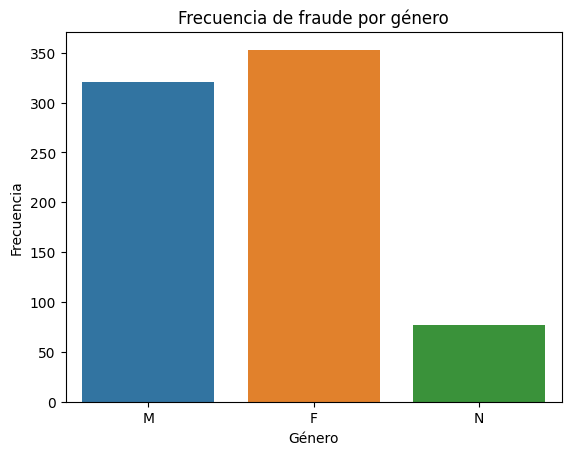

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Bar plot
sns.barplot(x='género', y='fraude', data=clean[clean['fraude'] == True], estimator=lambda x: len(x))

plt.xlabel('Género')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de fraude por género')

# Mostrar el bar plot
plt.show()

Parece ser que no hay mucha diferencia significativa entre los géneros 'M' y 'F' a la hora de cometer fraudes. El género 'N' tiene menos observaciones porque simplemente hay menos personas que se identifican con este género.

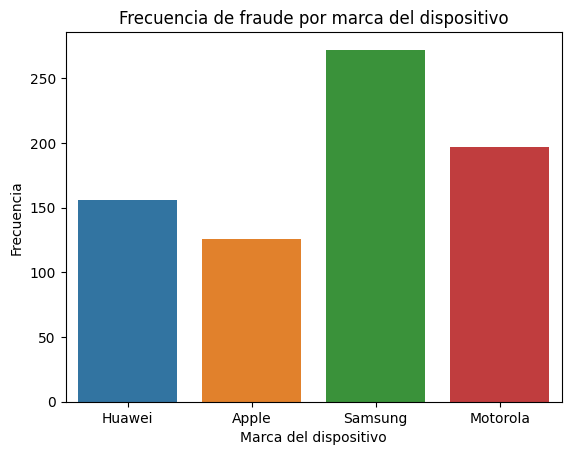

In [9]:
# Bar plot
sns.barplot(x='marca_dispositivo', y='fraude', data=clean[clean['fraude'] == True], estimator=lambda x: len(x))

plt.xlabel('Marca del dispositivo')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de fraude por marca del dispositivo')

# Mostrar el bar plot
plt.show()

Se realizan más fraudes con teléfonos Samsung y Motorola.

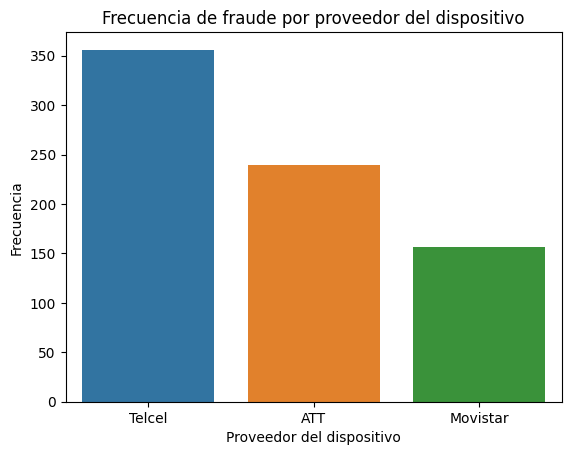

In [10]:
# Bar plot
sns.barplot(x='proveedor_dispositivo', y='fraude', data=clean[clean['fraude'] == True], estimator=lambda x: len(x))

plt.xlabel('Proveedor del dispositivo')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de fraude por proveedor del dispositivo')

# Mostrar el bar plot
plt.show()

La mayoría de los fraudes son hechos con teléfonos de Telcel. Nuevamente, de acuerdo con que es el mayor proveedor de línea telefónica en México.

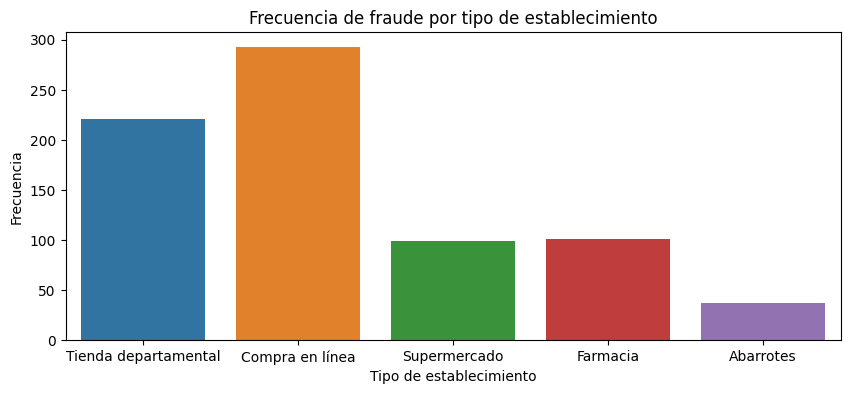

In [11]:
# Bar plot
plt.figure(figsize=(10, 4))
sns.barplot(x='establecimiento', y='fraude', data=clean[clean['fraude'] == True], estimator=lambda x: len(x))

plt.xlabel('Tipo de establecimiento')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de fraude por tipo de establecimiento')

# Mostrar el bar plot
plt.show()

La mayoría de los fraudes ocurren en compras en línea y tiendas departamentales.

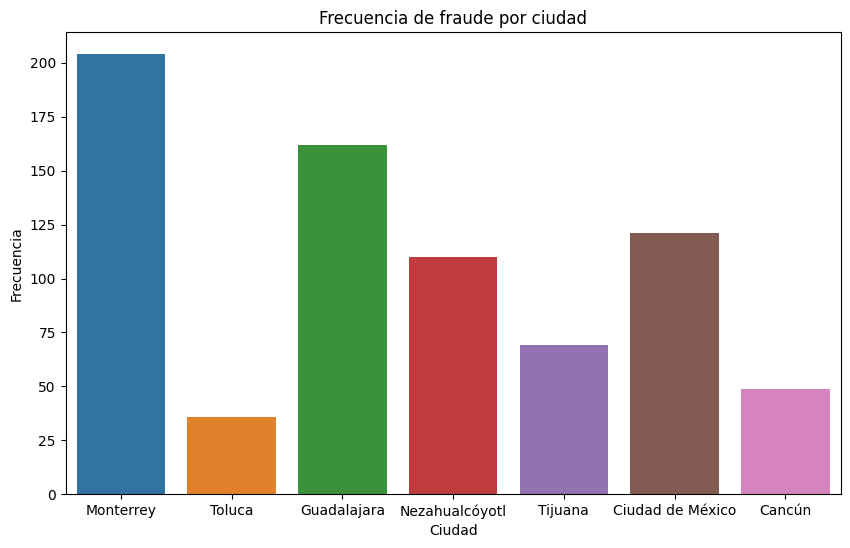

In [12]:
# Bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='ciudad', y='fraude', data=clean[clean['fraude'] == True], estimator=lambda x: len(x))

plt.xlabel('Ciudad')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de fraude por ciudad')

# Mostrar el bar plot
plt.show()

Se realizan más fraudes en las ciudades donde se realizan en general más transacciones.

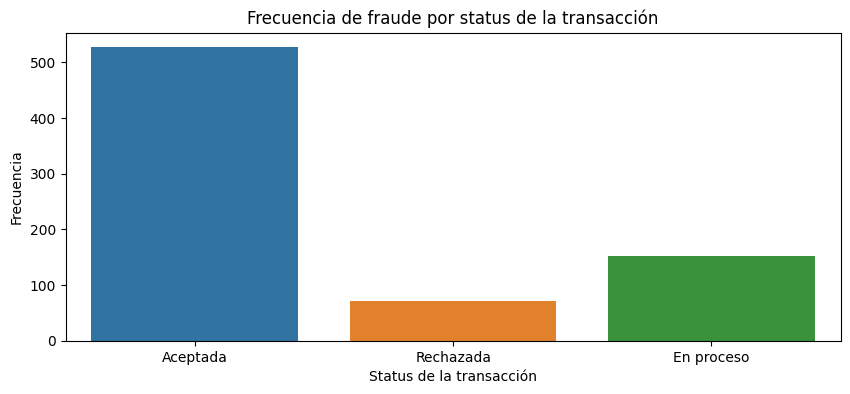

In [13]:
# Bar plot
plt.figure(figsize=(10, 4))
sns.barplot(x='status_txn', y='fraude', data=clean[clean['fraude'] == True], estimator=lambda x: len(x))

plt.xlabel('Status de la transacción')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de fraude por status de la transacción')

# Mostrar el bar plot
plt.show()

La mayoría de los fraudes ocurren para transacciones aceptadas.

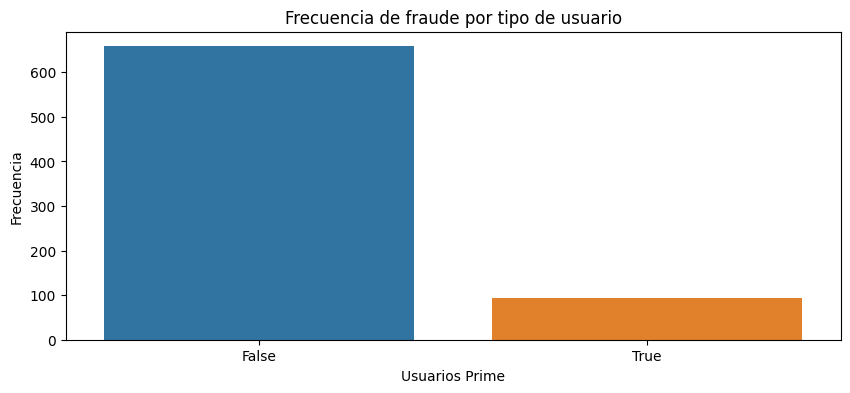

In [14]:
# Bar plot
plt.figure(figsize=(10, 4))
sns.barplot(x='is_prime', y='fraude', data=clean[clean['fraude'] == True], estimator=lambda x: len(x))

plt.xlabel('Usuarios Prime')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de fraude por tipo de usuario')

# Mostrar el bar plot
plt.show()

La mayoría de los fraudes son hechos por usuarios que no pertenecen a la membresía Prime.

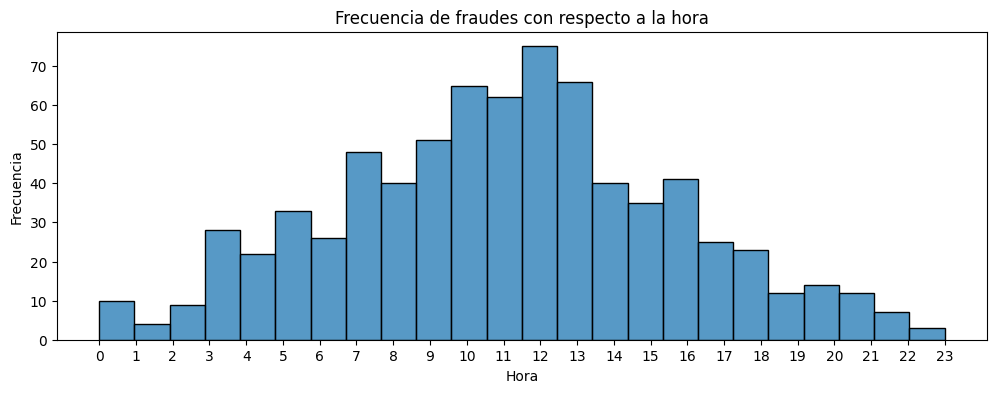

In [15]:
# Histograma
plt.figure(figsize=(12, 4))
sns.histplot(x='hora', data=clean[clean['fraude'] == True], bins=len(clean['hora'].unique()))

plt.xlabel('Hora')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de fraudes con respecto a la hora')
plt.xticks(range(int(clean['hora'].min()), int(clean['hora'].max()) + 1))

# Mostrar el histograma
plt.show()

La mayoría de los fraudes se ejecutan entre las 7 y 13 horas, siendo las 12 p.m. la hora más común.

<ipython-input-16-fa53b907e5d9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean['dia'] = clean['fecha'].dt.day


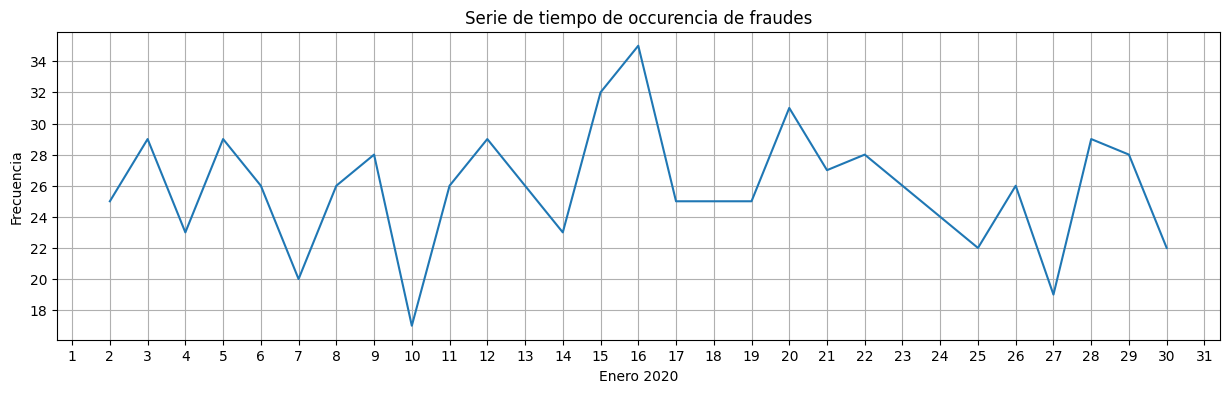

In [16]:
import matplotlib.ticker as ticker

plt.figure(figsize=(15, 4))

clean['dia'] = clean['fecha'].dt.day
clean.groupby('dia')['fraude'].sum().plot(kind='line')

plt.title('Serie de tiempo de occurencia de fraudes')
plt.xlabel('Enero 2020')
plt.ylabel('Frecuencia')

plt.grid(True)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.show()

clean = clean.drop('dia', axis=1)
clean['dia'] = clean['fecha'].dt.day_name()

La mayoría de los fraudes ocurrieron a mitad de mes.

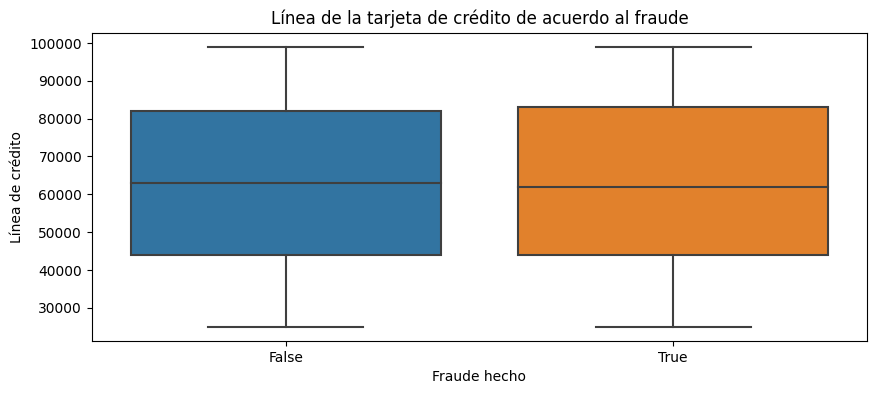

In [17]:
# Box plot
plt.figure(figsize=(10, 4))
sns.boxplot(x='fraude', y='linea_tc', data=clean)

plt.xlabel('Fraude hecho')
plt.ylabel('Línea de crédito')
plt.title('Línea de la tarjeta de crédito de acuerdo al fraude')

# Mostrar el bar plot
plt.show()

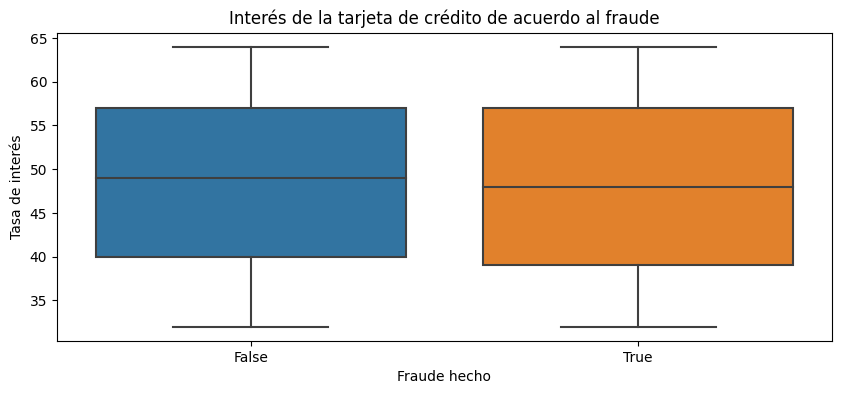

In [18]:
# Box plot
plt.figure(figsize=(10, 4))
sns.boxplot(x='fraude', y='interes_tc', data=clean)

plt.xlabel('Fraude hecho')
plt.ylabel('Tasa de interés')
plt.title('Interés de la tarjeta de crédito de acuerdo al fraude')

# Mostrar el bar plot
plt.show()

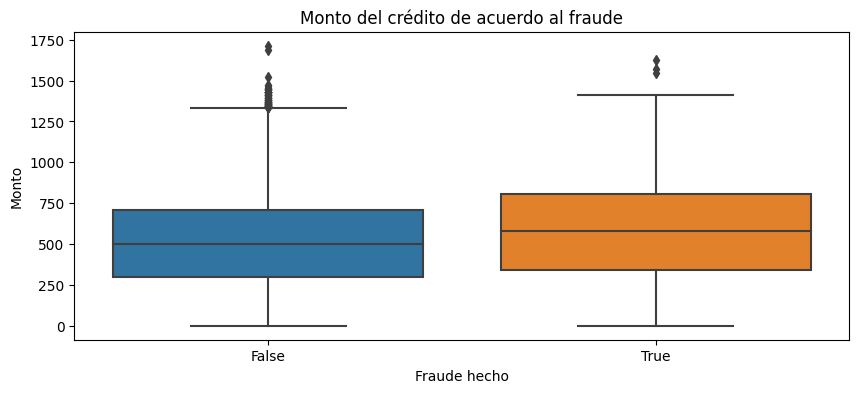

In [19]:
# Box plot
plt.figure(figsize=(10, 4))
sns.boxplot(x='fraude', y='monto', data=clean)

plt.xlabel('Fraude hecho')
plt.ylabel('Monto')
plt.title('Monto del crédito de acuerdo al fraude')

# Mostrar el bar plot
plt.show()

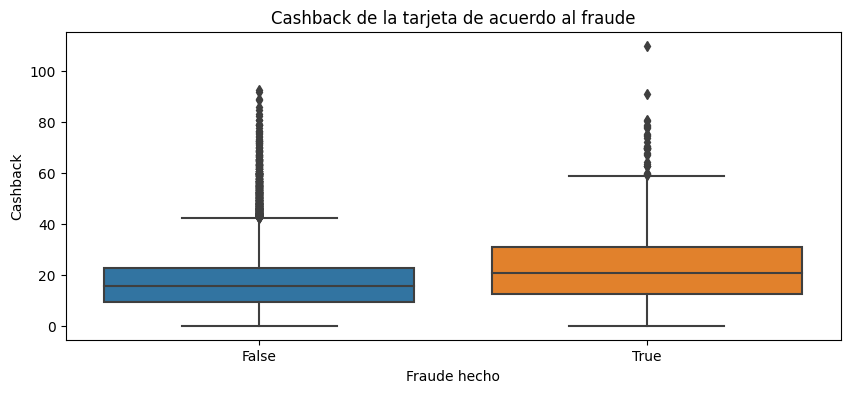

In [20]:
# Box plot
plt.figure(figsize=(10, 4))
sns.boxplot(x='fraude', y='cashback', data=clean)

plt.xlabel('Fraude hecho')
plt.ylabel('Cashback')
plt.title('Cashback de la tarjeta de acuerdo al fraude')

# Mostrar el bar plot
plt.show()

Parece que no hay diferencia en las líneas de crédito y tasas de interés entre transacciones fraudulentas y legítimas. Sin embargo, las transacciones fraudulentas se observan con una media mayor en los montos del crédito, sobretodo más inclinados hacia cuantiles superiores de la distribución de los datos. También se observaron más fraudes en transacciones con cashback mayores.

# Modelación

El primer paso para poder modelar es crear *dummies* para las variables categóricas. Se elimina el id de los usuarios y de la transacción porque no es relevante para el análisis. También se elimina la fecha porque al contar solo con un mes, no es posible verificar existe estacionalidad para transacciones fraudulentas a través de los meses.

In [11]:
clean_dummies = pd.get_dummies(clean)
clean2 = clean_dummies.drop(['user_id','transaction_id','fecha'], axis=1)

A continuación se observa la distribución de los valores de la base de datos.

In [12]:
clean2.describe()

,linea_tc,interes_tc,monto,hora,anio_dispositivo,dcto,cashback,género_F,género_M,género_N,...,ciudad_Cancún,ciudad_Ciudad de México,ciudad_Guadalajara,ciudad_Monterrey,ciudad_Nezahualcóyotl,ciudad_Tijuana,ciudad_Toluca,status_txn_Aceptada,status_txn_En proceso,status_txn_Rechazada
count,23746.000000,23746.000000,23746.000000,23746.000000,23746.000000,23746.000000,23746.000000,23746.000000,23746.000000,23746.000000,...,23746.000000,23746.000000,23746.000000,23746.000000,23746.000000,23746.000000,23746.000000,23746.000000,23746.000000,23746.000000
mean,62547.502737,48.218647,512.058296,12.657711,2018.752758,5.369338,16.878468,0.445801,0.460962,0.093237,...,0.060389,0.154721,0.224880,0.252169,0.162427,0.088689,0.056725,0.700118,0.196454,0.103428
std,21881.952204,9.586083,290.572063,5.666568,1.964192,12.321347,10.912881,0.497064,0.498484,0.290770,...,0.238211,0.361646,0.417512,0.434267,0.368850,0.284300,0.231322,0.458216,0.397324,0.304523
min,25000.000000,32.000000,1.000000,0.000000,2011.000000,0.000000,0.030000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,44000.000000,40.000000,298.320000,9.000000,2018.000000,0.000000,9.430000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,63000.000000,48.000000,503.890000,13.000000,2019.000000,0.000000,15.860000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,82000.000000,57.000000,714.190000,17.000000,2020.000000,0.000000,22.780000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,99000.000000,64.000000,1712.700000,23.000000,2022.000000,85.640000,109.730000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Muchos de los modelos de machine learning utilizan algún tipo de métrica para medir la distancia, por lo que variables con escalas más grandes pueden influenciar los modelos de forma desproporcionada. Por lo tanto, es conveniente escalar tales variables (linea_tc, interes_tc, monto y anio_dispositivo). dcto es en porcentaje, así que solo será dividida entre 100, mientras cashback parece no tener problemas pues la mayoría de los valores son pequeños en todos los cuantiles, excepto por los outliers.

Como linea_tc, interes_tc, monto y anio_dispositivo corresponden a variables con valores positivos, el reescalamiento se lleva a cabo con MinMax Scaling (restar el mínimo y dividir entre el rango de las observaciones).

In [13]:
from sklearn.preprocessing import MinMaxScaler

clean3 = clean2

scaler = MinMaxScaler()

clean3['dcto'] = clean2['dcto'] / 100
clean3[['linea_tc', 'interes_tc', 'monto', 'anio_dispositivo']] = scaler.fit_transform(clean2[['linea_tc', 'interes_tc', 'monto', 'anio_dispositivo']])

Ahora sí es momento de llevar a cabo varios modelos y compararlos. Más adelante se presenta la métrica para elegir los mejores modelos.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

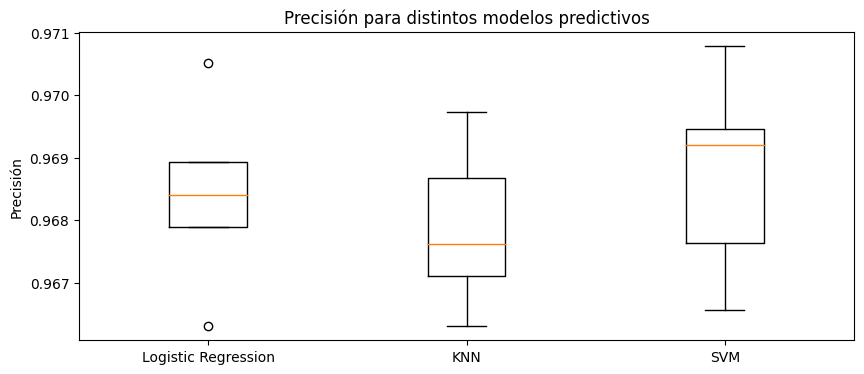

In [14]:
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

X = clean3.drop('fraude', axis=1).values
y = clean3['fraude'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 24)

models = {'Logistic Regression': LogisticRegression(),
          'KNN': KNeighborsClassifier(),
          'SVM': SVC()
          }

results = []
for model in models.values():
      kf = KFold(n_splits=5, random_state=24, shuffle=True)
      cv_results = cross_val_score(model, X_train, y_train, cv=kf)#, scoring='recall')
      results.append(cv_results)

plt.figure(figsize=(10, 4))

plt.boxplot(results, labels=models.keys())
plt.title('Precisión para distintos modelos predictivos')
plt.ylabel('Precisión')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

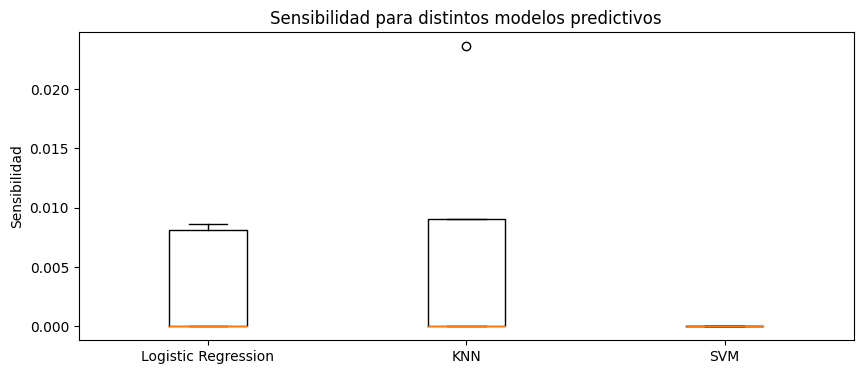

In [15]:
X = clean3.drop('fraude', axis=1).values
y = clean3['fraude'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 24)

models = {'Logistic Regression': LogisticRegression(),
          'KNN': KNeighborsClassifier(),
          'SVM': SVC()
          }

results = []
for model in models.values():
      kf = KFold(n_splits=5, random_state=24, shuffle=True)
      cv_results = cross_val_score(model, X_train, y_train, cv=kf, scoring='recall')
      results.append(cv_results)

plt.figure(figsize=(10, 4))

plt.boxplot(results, labels=models.keys())
plt.title('Sensibilidad para distintos modelos predictivos')
plt.ylabel('Sensibilidad')
plt.show()

# ¿Qué hacer?

Como podemos ver, la sensibilidad es muy baja, pero necesitamos que nuestro modelo sea más alto en sensibilidad porque necesitamos incrementar los verdaderos positivos, es decir, que cuando una transacción sea fraudulenta el modelo. Una sensibilidad alta significa que el modelo detecta la mayoría de las transacciones fraudulentas de manera correcta.

Una forma de hacer esto es a través del submuestreo .

Distribución de las clases después del submuestreo: Counter({False: 700, True: 700})


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

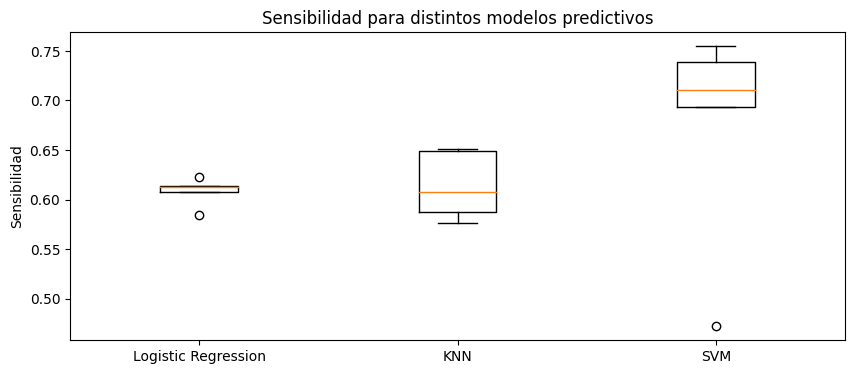

In [60]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Subdividimos la muestra
muestras = {
            True: 700,  # Número de transacciones fraudulentas
            False: 700   # Número de transacciones no-fraudulentas
           }

undersampler = RandomUnderSampler(sampling_strategy=muestras,random_state=2024)

X_resampled, y_resampled = undersampler.fit_resample(X, y)
print("Distribución de las clases después del submuestreo:", Counter(y_resampled))

X_nueva = pd.DataFrame(X_resampled, columns=clean3.drop('fraude', axis=1).columns)
y_nueva = pd.Series(y_resampled, name='fraude')

X_train, X_test, y_train, y_test = train_test_split(X_nueva, y_nueva, test_size = 0.2, random_state = 24)

models = {'Logistic Regression': LogisticRegression(),
          'KNN': KNeighborsClassifier(),
          'SVM': SVC()
          }

results = []
for model in models.values():
      kf = KFold(n_splits=5, random_state=24, shuffle=True)
      cv_results = cross_val_score(model, X_train, y_train, cv=kf, scoring='recall')
      results.append(cv_results)

plt.figure(figsize=(10, 4))

plt.boxplot(results, labels=models.keys())
plt.title('Sensibilidad para distintos modelos predictivos')
plt.ylabel('Sensibilidad')
plt.show()

Confusion Matrix:
 [[90 53]
 [55 82]]


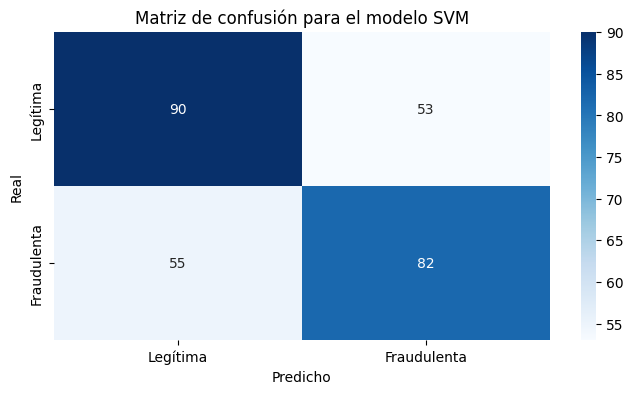

In [61]:
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

# Matriz de confusión:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

plt.figure(figsize=(8, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Legítima', 'Fraudulenta'], yticklabels=['Legítima', 'Fraudulenta'])
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title('Matriz de confusión para el modelo SVM')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix:
 [[90 53]
 [56 81]]


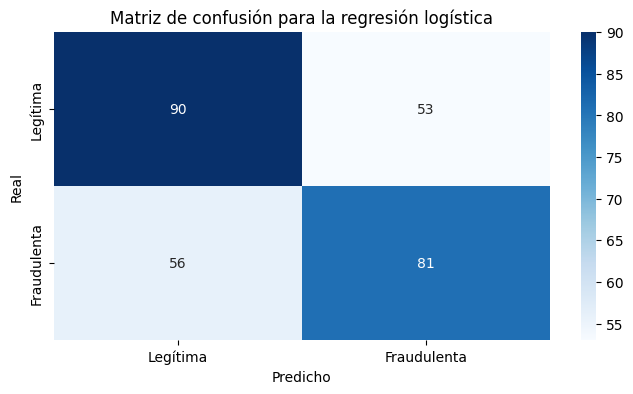

In [62]:
logistic_regression_model = models['Logistic Regression']
logistic_regression_model.fit(X_train, y_train)
y_pred = logistic_regression_model.predict(X_test)

# Matriz de confusión:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

plt.figure(figsize=(8, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Legítima', 'Fraudulenta'], yticklabels=['Legítima', 'Fraudulenta'])
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title('Matriz de confusión para la regresión logística')
plt.show()

SVM tiene una predicción ligeramente mejor de las observaciones fraudulentas, sin embargo, dado que se tienen muchas variables y no se puede observar la frontera de los datos, además que es difícil la interpretabilidad, elegiré el modelo de regresión logística.

In [58]:
coefficients = logistic_regression_model.coef_
intercept = logistic_regression_model.intercept_

# Coeficientes de la regresión e intercepto
print("Coefficients:", coefficients)
print("Intercept:", intercept)

Coefficients: [[ 0.08485381  0.13659635 -2.27486909 -0.07407094 -2.33308759 -0.15598013
   0.92831491  0.05931262  0.1620193   0.06347941  0.42704337  0.05491541
   0.13345042  0.03799779  0.42617846  0.26598803  0.19034181  0.19621224
  -0.38554319  0.78593821 -0.08635267  0.1405441   0.19795563  0.37687733
   0.36915633  0.04081094  0.07188734  0.04803303  0.0186641  -0.27288699
   0.21132021  0.36366923  0.07755265]]
Intercept: [0.82113603]


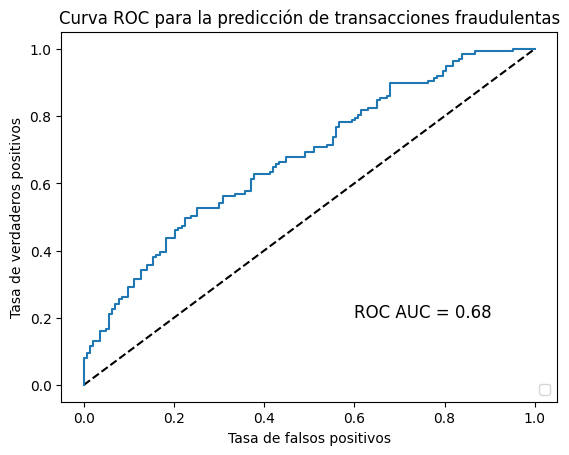

In [63]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

y_pred_probs = logistic_regression_model.predict_proba(X_test)[:, 1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

plt.plot([0, 1], [0, 1], 'k--')

# Plot tpr against fpr
plt.plot(fpr, tpr)
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC para la predicción de transacciones fraudulentas')
plt.legend(loc='lower right')
plt.text(0.6, 0.2, 'ROC AUC = {:.2f}'.format(roc_auc_score(y_test, y_pred_probs).round(2)), fontsize=12)

plt.show()

La discriminación del modelo es pobre, si bien muy cercana a aceptable (0.7). Tomando con árboles aleatorios las variables de mayor importancia vemos que se obtiene un modelo con la misma sensibilidad que el completo. Por principio de parsimonia, elegimos el modelo con menos variables.

In [66]:
from sklearn.ensemble import RandomForestClassifier

# Subdividimos la muestra
muestras = {
            True: 700,  # Número de transacciones fraudulentas
            False: 700   # Número de transacciones no-fraudulentas
           }

undersampler = RandomUnderSampler(sampling_strategy=muestras,random_state=2024)

X_resampled, y_resampled = undersampler.fit_resample(X, y)
print("Distribución de las clases después del submuestreo:", Counter(y_resampled))

X_nueva = pd.DataFrame(X_resampled, columns=clean2.drop('fraude', axis=1).columns)
y_nueva = pd.Series(y_resampled, name='fraude')

X_train, X_test, y_train, y_test = train_test_split(X_nueva, y_nueva, test_size = 0.2, random_state = 24)

# Entrenar un clasificador de Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_nueva, y_nueva)

# Get feature importances
feature_importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
sorted_feature_importance = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print feature importances
for feature, importance in zip(X_nueva.columns, feature_importances):
    print(f"{feature}: {importance}")

Distribución de las clases después del submuestreo: Counter({False: 700, True: 700})
linea_tc: 0.08981060048249308
interes_tc: 0.08203035215665881
monto: 0.09962219552555297
hora: 0.11591019376116608
anio_dispositivo: 0.09968912848369958
is_prime: 0.01251756967152881
dcto: 0.035589364724076526
cashback: 0.13909005232814753
género_F: 0.015961824720611324
género_M: 0.01652982450798882
género_N: 0.009673234269689955
marca_dispositivo_Apple: 0.012749001689181708
marca_dispositivo_Huawei: 0.013904737033499013
marca_dispositivo_Motorola: 0.014317475819876904
marca_dispositivo_Samsung: 0.01541000930685076
proveedor_dispositivo_ATT: 0.013683114518353084
proveedor_dispositivo_Movistar: 0.014769930144957696
proveedor_dispositivo_Telcel: 0.015939650607012825
establecimiento_Abarrotes: 0.008894698510213912
establecimiento_Compra en línea: 0.023360025815077973
establecimiento_Farmacia: 0.012101102962426799
establecimiento_Supermercado: 0.011713554663992631
establecimiento_Tienda departamental: 0.01

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


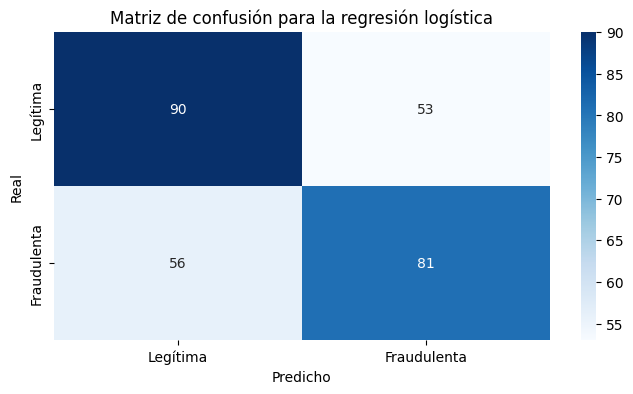

In [160]:
variables_a_conservar = ['cashback','monto','linea_tc','hora','interes_tc','anio_dispositivo','dcto','establecimiento_Compra en línea','proveedor_dispositivo_Telcel','género_F','género_M']

X2 = X_nueva[variables_a_conservar]
y2 = y_nueva

X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size = 0.2, random_state = 24)

logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(X_train, y_train)
y_pred = logistic_regression_model.predict(X_test)

# Matriz de confusión
plt.figure(figsize=(8, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Legítima', 'Fraudulenta'], yticklabels=['Legítima', 'Fraudulenta'])
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title('Matriz de confusión para la regresión logística')
plt.show()

In [161]:
coefficients = logistic_regression_model.coef_.round(2)
intercept = logistic_regression_model.intercept_.round(2)

# Coeficientes de la regresión e intercepto
print("Coefficients:", coefficients)
print("Intercept:", intercept)

Coefficients: [[ 0.06 -2.69  0.16 -0.08  0.13 -2.37  1.09  0.71  0.01 -0.06 -0.19]]
Intercept: [1.77]


$$ p(x) = \frac{1}{1+\exp^{-(1.77+0.06*cashback -2.69*monto +0.16*linea -0.08*hora +0.13*int -2.37*año +1.09*dcto +0.71*EnLinea +0.01*Telcel -0.06*Fem -0.19*Masc)}}$$

Debido al escalamiento de los datos,

linea_tc cambia $\frac{x-25000}{99000-25000}$

interes_tc cambia $\frac{x-32}{64-32}$

monto cambia $\frac{x-1}{1712.7-1}$

año cambia $\frac{x-2011}{2022-2011}$

dcto cambia $1/100$, es decir, los aumentos unitarios son de

linea_tc cambia $\frac{1}{99000-25000} = 0.000013$

interes_tc cambia $\frac{1}{64-32} = 0.03$

monto cambia $\frac{1}{1712.7-1} = 0.0006$

año cambia $\frac{1}{2022-2011} = 0.09$

dcto cambia $0.01$.

In [200]:
1/(1+np.exp(-(1.77 +0.06*0.03 -2.69*0 +0.16*0 -0.08*0 +0.13*0 -2.37*0 +1.09*0 +0.71*0 +0.01*0 -0.06*0 -0.19*0)))

0.8546813758406246

In [211]:
# cashback
1/(1+np.exp(-(1.77 +0.06*1.03 -2.69*0 +0.16*0 -0.08*0 +0.13*0 -2.37*0 +1.09*0 +0.71*0 +0.01*0 -0.06*0 -0.19*0))) - 1/(1+np.exp(-(1.77 +0.06*0.03 -2.69*0 +0.16*0 -0.08*0 +0.13*0 -2.37*0 +1.09*0 +0.71*0 +0.01*0 -0.06*0 -0.19*0)))

0.007294642603917878

In [212]:
# monto
1/(1+np.exp(-(1.77 +0.06*0.03 -2.69*0.0006 +0.16*0 -0.08*0 +0.13*0 -2.37*0 +1.09*0 +0.71*0 +0.01*0 -0.06*0 -0.19*0))) - 1/(1+np.exp(-(1.77 +0.06*0.03 -2.69*0 +0.16*0 -0.08*0 +0.13*0 -2.37*0 +1.09*0 +0.71*0 +0.01*0 -0.06*0 -0.19*0)))

-0.00020057538730422486

In [213]:
# linea_tc
1/(1+np.exp(-(1.77 +0.06*0.03 -2.69*0 +0.16*0.000013 -0.08*0 +0.13*0 -2.37*0 +1.09*0 +0.71*0 +0.01*0 -0.06*0 -0.19*0))) - 1/(1+np.exp(-(1.77 +0.06*0.03 -2.69*0 +0.16*0 -0.08*0 +0.13*0 -2.37*0 +1.09*0 +0.71*0 +0.01*0 -0.06*0 -0.19*0)))

2.5833814243370057e-07

In [214]:
# hora
1/(1+np.exp(-(1.77 +0.06*0.03 -2.69*0 +0.16*0 -0.08*1 +0.13*0 -2.37*0 +1.09*0 +0.71*0 +0.01*0 -0.06*0 -0.19*0))) - 1/(1+np.exp(-(1.77 +0.06*0.03 -2.69*0 +0.16*0 -0.08*0 +0.13*0 -2.37*0 +1.09*0 +0.71*0 +0.01*0 -0.06*0 -0.19*0)))

-0.010220645098416359

In [215]:
# interes_tc
1/(1+np.exp(-(1.77 +0.06*0.03 -2.69*0 +0.16*0 -0.08*0 +0.13*0.03 -2.37*0 +1.09*0 +0.71*0 +0.01*0 -0.06*0 -0.19*0))) - 1/(1+np.exp(-(1.77 +0.06*0.03 -2.69*0 +0.16*0 -0.08*0 +0.13*0 -2.37*0 +1.09*0 +0.71*0 +0.01*0 -0.06*0 -0.19*0)))

0.0004837146593903441

In [216]:
# año
1/(1+np.exp(-(1.77 +0.06*0.03 -2.69*0 +0.16*0 -0.08*0 +0.13*0 -2.37*0.09 +1.09*0 +0.71*0 +0.01*0 -0.06*0 -0.19*0))) - 1/(1+np.exp(-(1.77 +0.06*0.03 -2.69*0 +0.16*0 -0.08*0 +0.13*0 -2.37*0 +1.09*0 +0.71*0 +0.01*0 -0.06*0 -0.19*0)))

-0.028543368470892894

In [217]:
# dcto
1/(1+np.exp(-(1.77 +0.06*0.03 -2.69*0 +0.16*0 -0.08*0 +0.13*0 -2.37*0 +1.09*0.01 +0.71*0 +0.01*0 -0.06*0 -0.19*0))) - 1/(1+np.exp(-(1.77 +0.06*0.03 -2.69*0 +0.16*0 -0.08*0 +0.13*0 -2.37*0 +1.09*0 +0.71*0 +0.01*0 -0.06*0 -0.19*0)))

0.001348565284097769

In [218]:
# Compra en línea
1/(1+np.exp(-(1.77 +0.06*0.03 -2.69*0 +0.16*0 -0.08*0 +0.13*0 -2.37*0 +1.09*0 +0.71*1 +0.01*0 -0.06*0 -0.19*0))) - 1/(1+np.exp(-(1.77 +0.06*0.03 -2.69*0 +0.16*0 -0.08*0 +0.13*0 -2.37*0 +1.09*0 +0.71*0 +0.01*0 -0.06*0 -0.19*0)))

0.06817466658156213

In [219]:
# Telcel
1/(1+np.exp(-(1.77 +0.06*0.03 -2.69*0 +0.16*0 -0.08*0 +0.13*0 -2.37*0 +1.09*0 +0.71*0 +0.01*1 -0.06*0 -0.19*0))) - 1/(1+np.exp(-(1.77 +0.06*0.03 -2.69*0 +0.16*0 -0.08*0 +0.13*0 -2.37*0 +1.09*0 +0.71*0 +0.01*0 -0.06*0 -0.19*0)))

0.0012376113260287314

In [220]:
# Femenino
1/(1+np.exp(-(1.77 +0.06*0.03 -2.69*0 +0.16*0 -0.08*0 +0.13*0 -2.37*0 +1.09*0 +0.71*0 +0.01*0 -0.06*1 -0.19*0))) - 1/(1+np.exp(-(1.77 +0.06*0.03 -2.69*0 +0.16*0 -0.08*0 +0.13*0 -2.37*0 +1.09*0 +0.71*0 +0.01*0 -0.06*0 -0.19*0)))

-0.0076117690677190986

In [221]:
# Masculino
1/(1+np.exp(-(1.77 +0.06*0.03 -2.69*0 +0.16*0 -0.08*0 +0.13*0 -2.37*0 +1.09*0 +0.71*0 +0.01*0 -0.06*0 -0.19*1))) - 1/(1+np.exp(-(1.77 +0.06*0.03 -2.69*0 +0.16*0 -0.08*0 +0.13*0 -2.37*0 +1.09*0 +0.71*0 +0.01*0 -0.06*0 -0.19*0)))

-0.025222085008444806